data: https://www.kaggle.com/datasets/cendekialuthfietanz/caisim

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset dan Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [20]:
bs = 64 # changed
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.3),  # Added vertical flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Small translations
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(80),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('data/train/', transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder('data/test/', transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [21]:
feature, target = next(iter(trainloader))
feature.shape, target.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

In [22]:
label2cat = train_set.classes
label2cat

['pest', 'without_pest']

# Arsitektur dan coding

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), 
            # output = (64, 8, 64, 64) -> input to layer 2, 64 as input_size to layer 2
            nn.ReLU(),
            nn.MaxPool2d(2,2), #maxpool = 2x2, output = (64, 8, 32, 32) -> input to layer 2
            nn.Dropout2d(0.2),

            nn.Conv2d(16, 32, 3, 1, 1), #output = (64, 32, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #maxpool = 2x2, output = (64, 32, 16, 16) -> input to layer 3
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 64, 3, 1, 1), # output = (64, 64, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # maxpool = 2x2, output = (64, 64, 8, 8) -> input to layer 4
            nn.Dropout2d(0.3),

            nn.Flatten() # output = (32, 64*8*8 = 2048) 
        )

        self.fc = nn.Sequential(
            nn.Linear(4096, 256), 
            nn.ReLU(),
            nn.Dropout(0.5), #changed

            nn.Linear(256, 2), # num_classes = 2
            nn.LogSoftmax(1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

# note : output_size = (input_size + 2*padding - kernel_size)/stride + 1

In [8]:
config = set_config({
    "batch_size":bs, # bs = 64
    "crop_size": crop_size # crop_size = 64
})

# Training Preparation

In [9]:
model = CNN().to(device)
criterion = nn.NLLLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
callback = Callback(model, config, outdir='model')

# Training

In [10]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc = mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature) # feedforward
        loss = criterion(output, target) # hitung loss

        if mode == 'train':
            loss.backward()
            optimizer.step() # update weight
            optimizer.zero_grad()

        cost = cost + loss.item() * feature.shape[0]
        correct = correct + (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6814 | Test_cost  = 0.6605 | Train_score = 0.5469 | Test_score = 0.6601 |


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6190 | Test_cost  = 0.5749 | Train_score = 0.6306 | Test_score = 0.6993 |


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.5527 | Test_cost  = 0.6295 | Train_score = 0.7157 | Test_score = 0.6209 |
==> EarlyStop patience =  1 | Best test_score: 0.6993


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5332 | Test_cost  = 0.6251 | Train_score = 0.7100 | Test_score = 0.6209 |
==> EarlyStop patience =  2 | Best test_score: 0.6993


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5528 | Test_cost  = 0.6345 | Train_score = 0.7143 | Test_score = 0.6078 |
==> EarlyStop patience =  3 | Best test_score: 0.6993


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.5319 | Test_cost  = 0.4990 | Train_score = 0.7345 | Test_score = 0.7647 |


Train:   0%|          | 0/11 [02:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4908 | Test_cost  = 0.5338 | Train_score = 0.7633 | Test_score = 0.7353 |
==> EarlyStop patience =  1 | Best test_score: 0.7647


Train:   0%|          | 0/11 [00:01<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4692 | Test_cost  = 0.4989 | Train_score = 0.7720 | Test_score = 0.7614 |
==> EarlyStop patience =  2 | Best test_score: 0.7647


Train:   0%|          | 0/11 [00:01<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4594 | Test_cost  = 0.6730 | Train_score = 0.7706 | Test_score = 0.6275 |
==> EarlyStop patience =  3 | Best test_score: 0.7647


Train:   0%|          | 0/11 [00:01<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.5142 | Test_cost  = 0.4739 | Train_score = 0.7460 | Test_score = 0.8105 |


Train:   0%|          | 0/11 [00:01<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.4644 | Test_cost  = 0.4155 | Train_score = 0.7965 | Test_score = 0.8203 |


Train:   0%|          | 0/11 [00:01<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.4506 | Test_cost  = 0.4897 | Train_score = 0.7922 | Test_score = 0.7549 |
==> EarlyStop patience =  1 | Best test_score: 0.8203


Train:   0%|          | 0/11 [00:01<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.3866 | Test_cost  = 0.4539 | Train_score = 0.8225 | Test_score = 0.7810 |
==> EarlyStop patience =  2 | Best test_score: 0.8203


Train:   0%|          | 0/11 [00:01<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3898 | Test_cost  = 0.3771 | Train_score = 0.8398 | Test_score = 0.8497 |


Train:   0%|          | 0/11 [00:01<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.4081 | Test_cost  = 0.4310 | Train_score = 0.8240 | Test_score = 0.7908 |
==> EarlyStop patience =  1 | Best test_score: 0.8497


Train:   0%|          | 0/11 [00:01<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.4215 | Test_cost  = 0.4417 | Train_score = 0.8052 | Test_score = 0.7843 |
==> EarlyStop patience =  2 | Best test_score: 0.8497


Train:   0%|          | 0/11 [00:01<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.3982 | Test_cost  = 0.3386 | Train_score = 0.8312 | Test_score = 0.8562 |


Train:   0%|          | 0/11 [03:01<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3799 | Test_cost  = 0.3492 | Train_score = 0.8283 | Test_score = 0.8399 |
==> EarlyStop patience =  1 | Best test_score: 0.8562


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3930 | Test_cost  = 0.3767 | Train_score = 0.8326 | Test_score = 0.8627 |


Train:   0%|          | 0/11 [00:02<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.4207 | Test_cost  = 0.3630 | Train_score = 0.8153 | Test_score = 0.8562 |


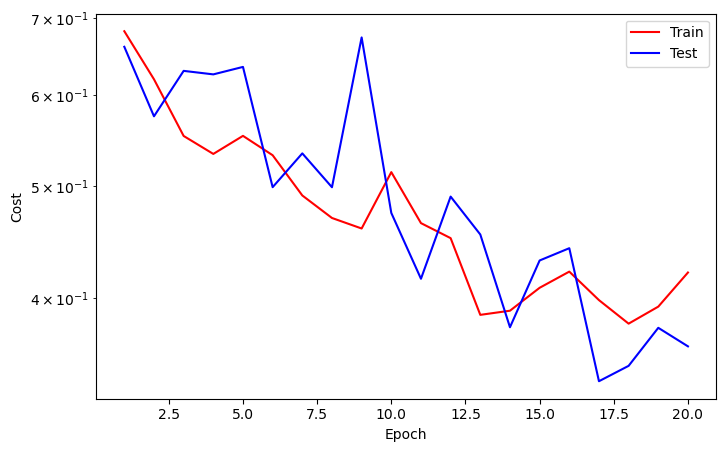

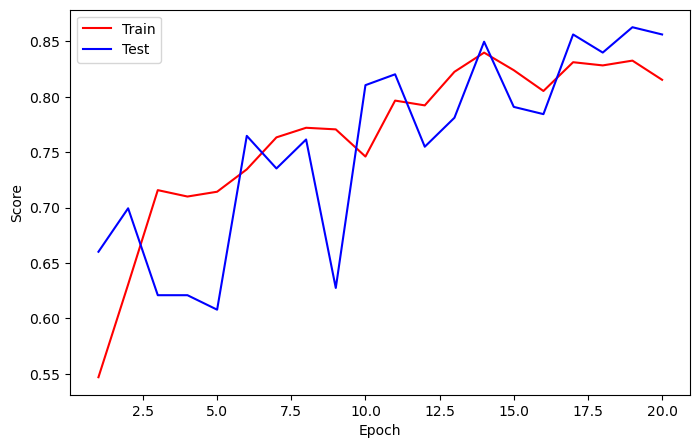

==> EarlyStop patience =  1 | Best test_score: 0.8627


Train:   0%|          | 0/11 [00:01<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.4183 | Test_cost  = 0.4382 | Train_score = 0.8110 | Test_score = 0.8072 |
==> EarlyStop patience =  2 | Best test_score: 0.8627


Train:   0%|          | 0/11 [00:01<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.3837 | Test_cost  = 0.4664 | Train_score = 0.8196 | Test_score = 0.7908 |
==> EarlyStop patience =  3 | Best test_score: 0.8627


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.3870 | Test_cost  = 0.4068 | Train_score = 0.8341 | Test_score = 0.8333 |
==> EarlyStop patience =  4 | Best test_score: 0.8627


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.3924 | Test_cost  = 0.3241 | Train_score = 0.8095 | Test_score = 0.8725 |


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.3889 | Test_cost  = 0.3719 | Train_score = 0.8240 | Test_score = 0.8366 |
==> EarlyStop patience =  1 | Best test_score: 0.8725


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.3850 | Test_cost  = 0.3716 | Train_score = 0.8600 | Test_score = 0.8268 |
==> EarlyStop patience =  2 | Best test_score: 0.8725


Train:   0%|          | 0/11 [00:01<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.3931 | Test_cost  = 0.4783 | Train_score = 0.8442 | Test_score = 0.7778 |
==> EarlyStop patience =  3 | Best test_score: 0.8725


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.3675 | Test_cost  = 0.4164 | Train_score = 0.8499 | Test_score = 0.8170 |
==> EarlyStop patience =  4 | Best test_score: 0.8725


Train:   0%|          | 0/11 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.3942 | Test_cost  = 0.3561 | Train_score = 0.8355 | Test_score = 0.8627 |
==> EarlyStop patience =  5 | Best test_score: 0.8725
==> Execute Early Stopping at epoch: 29 | Best test_score: 0.8725
==> Best model is saved at model


c:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\jcopdl\callback\_callback.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f'{self.outdir}/w

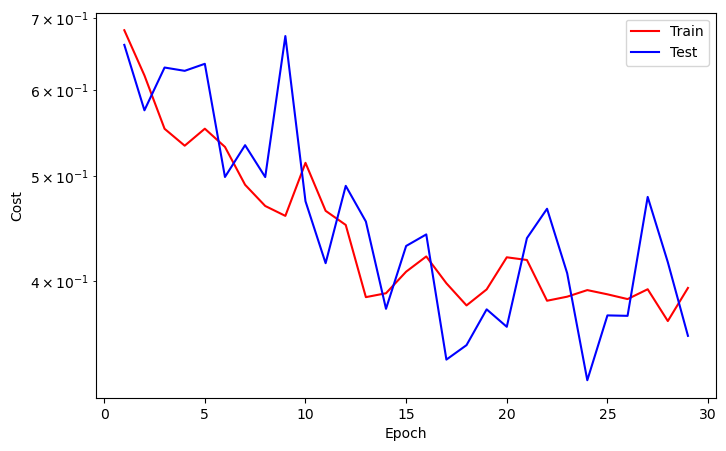

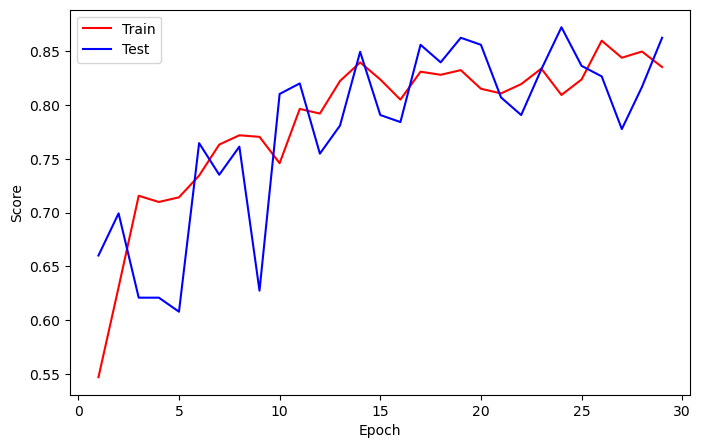

In [11]:
while True:
    train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break

# Evaluation

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for feature, target in tqdm(testloader, desc="Final Evaluation"):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        preds = output.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

Final Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
#Confusion Matrix and Classification Report
cm = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(cm)
print()

Confusion Matrix:
[[125  28]
 [ 11 142]]



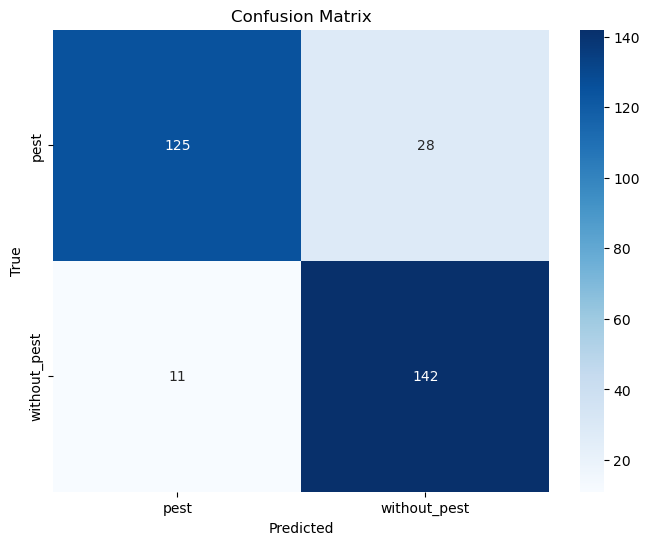

In [23]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label2cat, yticklabels=label2cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Generate classification report
report = classification_report(all_targets, all_preds, target_names=label2cat)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        pest       0.92      0.82      0.87       153
without_pest       0.84      0.93      0.88       153

    accuracy                           0.87       306
   macro avg       0.88      0.87      0.87       306
weighted avg       0.88      0.87      0.87       306



# Predict

In [25]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [26]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds, target   

(tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
         0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
         1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]),
 tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
         0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
         1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1]))

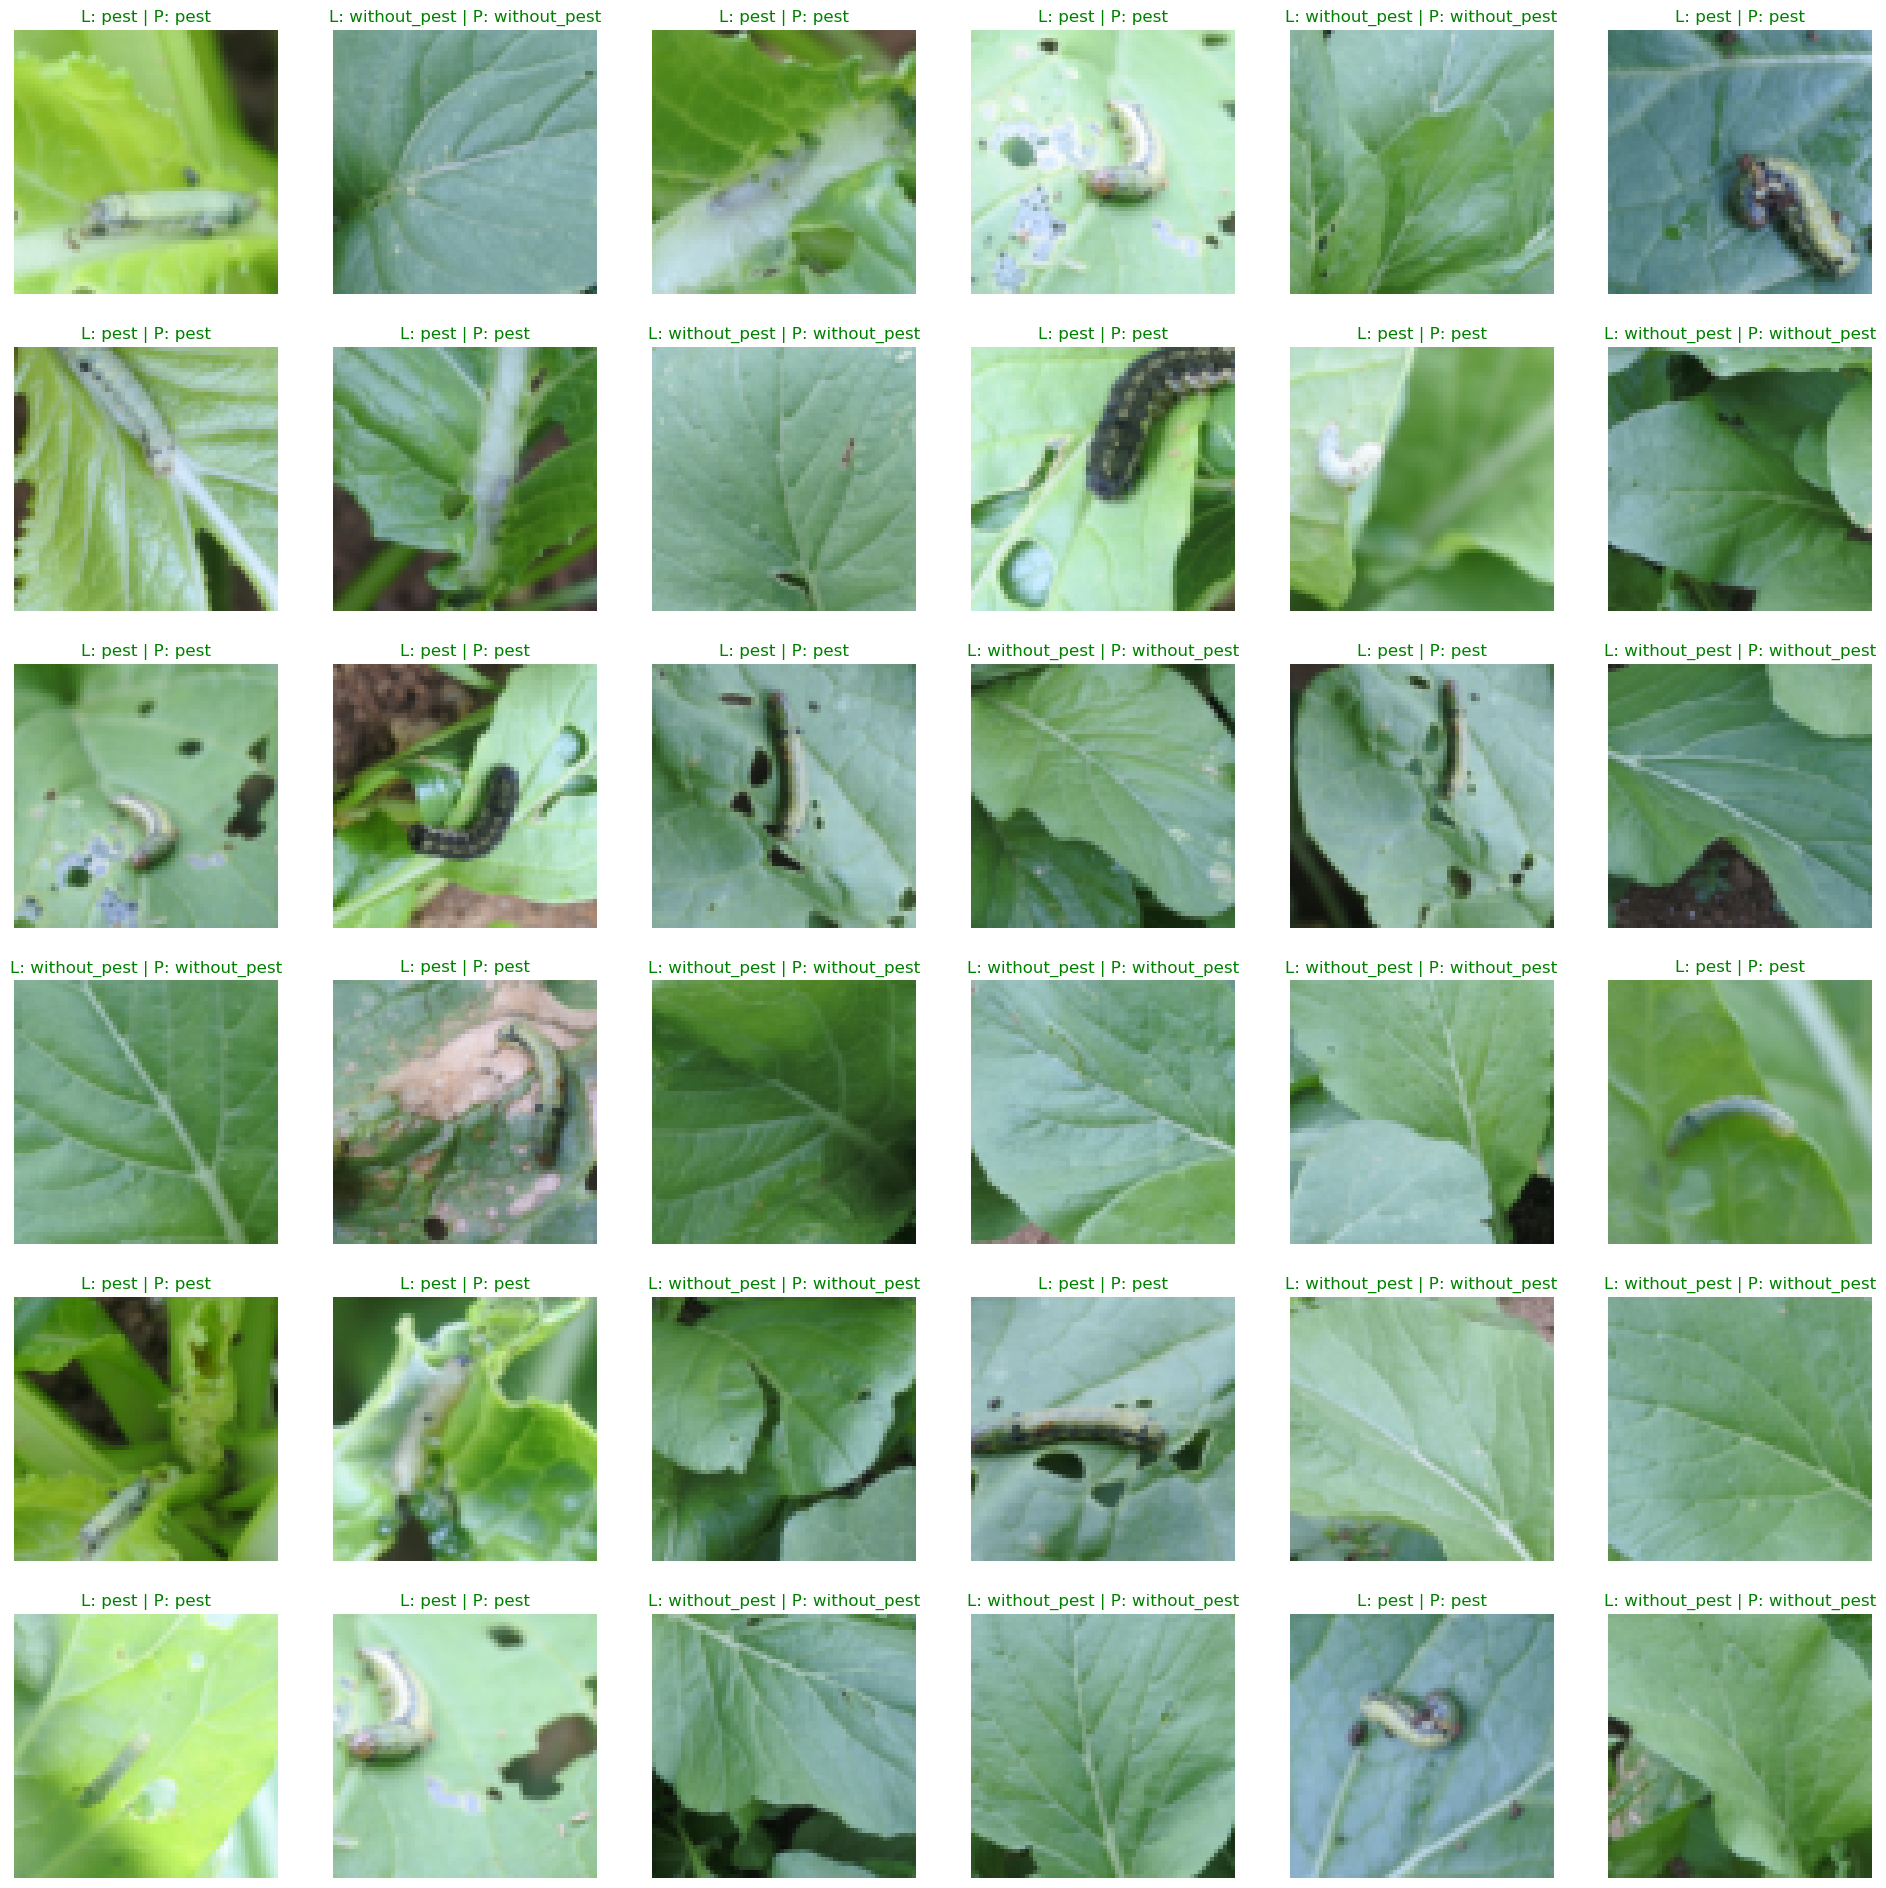

In [27]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(24,24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1,2, 0).cpu())
    font = {'color':'r'} if label != pred else {'color':'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f'L: {label} | P: {pred}', fontdict=font)
    ax.axis('off')